# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## Data Validation

For data validation each step will be detailed in comments below.

As you will see, general Data Validation results in the following:

* **recipe:** type int64, 947 unique values for 947 rows. So indeed numeric and unique. No need for change.

* **calories, carbohydrate, sugar, protein:** all type float64 with 52 NA values. We checked that the NA values all happen in the same rows, together. Approach for each row (i.e. dish) will be to fillNA with the mean value of the category of the dish weighted by the number fo servings. That is, for each category we find the mean value of 'calories, carbohydrate, sugar, protein' for 1 serving, and multiply by the number fo servings for the specific dish. 

* **category:** type object with 11 unique values. First of all, 'Chicken Breast' and Chicken will be grouped into one category to be aligned with Data Information from the exam PDF received. After that we will LabelEconde this category to perform classification analysis.
 
* **servings:** type object. There are categories '4 as a snack', '6 as a snack', which will be respectively turned into '4' and '6' as I will explain further. We will, then, turn it into type int64.

* **high_traffic:** there is no 'Not_High' category. Indeed, as detaild in the exam PDF received , 'if the traffic to the site was high when this recipe was shown, this is marked with “High”.' with nothing being mentioned for non-high traffic. We will substitute NA values with 'Not_High' and then use a LabelEnconder to this parameter for Classification purposes.

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [517]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [518]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [519]:
df.head(30)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,NaN


In [520]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [521]:
df.nunique()

recipe          947
calories        891
carbohydrate    835
sugar           666
protein         772
category         11
servings          6
high_traffic      1
dtype: int64

Below we can see that servings initially has '4 as a snack', '6 as a snack' as categories. We could be in doubt of how this would translate into other meals number of servings. But further investigating the servings column for the category 'Lunch/Snacks' we find that there are all the other servings categories ('4', '6', '2', '1'). So we will simply substitute '4 as a snack' by '4' and '6 as a snack' by '6' and turn this category into int64 type.

In [522]:
print(df.servings.unique())
df[df.category=='Lunch/Snacks'].servings.value_counts()


['6' '4' '1' '2' '4 as a snack' '6 as a snack']


4               34
6               20
1               17
2               15
4 as a snack     2
6 as a snack     1
Name: servings, dtype: int64

In [523]:
df.loc[df.servings == '4 as a snack', 'servings'] = '4'
df.loc[df.servings == '6 as a snack', 'servings'] = '6'
df['servings'] = df['servings'].astype('int64')
df[df.category=='Lunch/Snacks'].servings.value_counts()

4    36
6    21
1    17
2    15
Name: servings, dtype: int64

In [524]:
df.high_traffic.unique()

array(['High', nan], dtype=object)

We will change all nan in high_traffic by Low, as we noticed we do not have a Low category.

In [525]:
df['high_traffic'].fillna('Not_High', inplace=True)
df['high_traffic'].unique()

array(['High', 'Not_High'], dtype=object)

In [526]:
print(df.category.value_counts())
df.groupby('category').apply(lambda group: group.isna().any(axis=1).sum())

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


category
Beverages          0
Breakfast          0
Chicken            5
Chicken Breast     4
Dessert            6
Lunch/Snacks       7
Meat               5
One Dish Meal      4
Pork              11
Potato             5
Vegetable          5
dtype: int64

For the category column, let us first have a descriptive analysis of columns 'Chicken' and 'Chicken Breast' to understand if there is similiraty on both and make a stronger argument to merge them into one category 'Chicken':

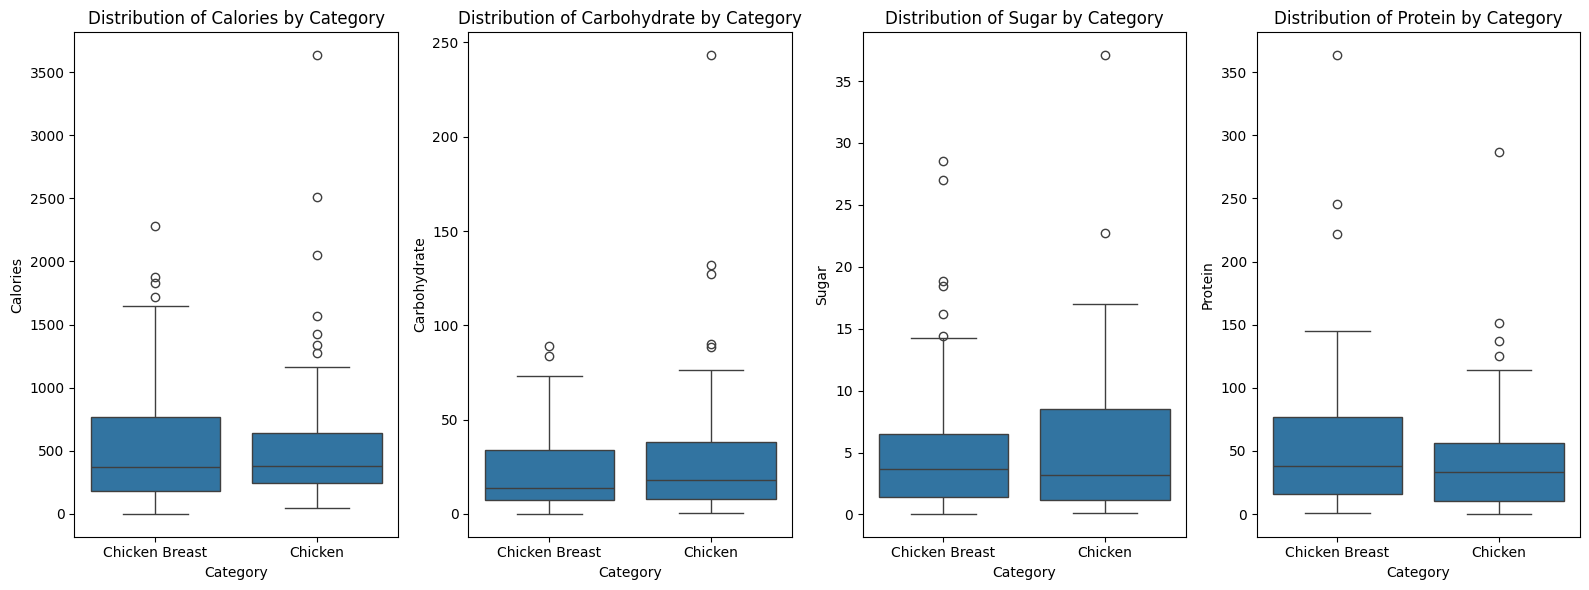

In [527]:
columns_to_fill = ['calories', 'carbohydrate', 'sugar', 'protein']
filtered_df = df[df['category'].isin(['Chicken', 'Chicken Breast'])]
fig, axes = plt.subplots(1, len(columns_to_fill), figsize=(16, 6), sharey=False)

for i, var in enumerate(columns_to_fill):
    sns.boxplot(data=filtered_df, x='category', y=var, ax=axes[i])
    axes[i].set_title(f'Distribution of {var.capitalize()} by Category')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel(var.capitalize())

plt.tight_layout()
plt.show()

In [528]:
print(filtered_df.groupby('category')[columns_to_analyze].describe().transpose())

category                Chicken  Chicken Breast
calories     count    69.000000       94.000000
             mean    566.732029      540.338511
             std     588.718095      504.052752
             min      46.660000        0.800000
             25%     248.280000      182.642500
             50%     379.870000      371.335000
             75%     642.710000      769.817500
             max    3633.160000     2283.290000
carbohydrate count    69.000000       94.000000
             mean     30.751304       21.833191
             std      38.187365       20.154644
             min       0.410000        0.030000
             25%       7.930000        7.340000
             50%      18.110000       13.475000
             75%      38.090000       33.615000
             max     243.200000       89.200000
sugar        count    69.000000       94.000000
             mean      5.678261        5.098723
             std       6.220433        5.455626
             min       0.130000        0

Indeed there is similarity as shown above in the boxplot and descriptive table. We will then merge the two categories.

In [529]:
df.loc[df.category == 'Chicken Breast', 'category'] = 'Chicken'
df.category.unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

Below we find that NA values for 'calories', 'carbohydrate', 'sugar', 'protein' alwayas occur together, as for each category there are 52 NA values as stated above.

In [530]:
len(df[df[columns_to_fill].isna().all(axis=1)])

52

For a row that has NA values in calories,carbohydrate, sugar, protein we will fillNA with 'mean' weighted by the number of servings, grouping by the category of the dish. That is, if a dish is up to 4 servings, is in 'Pork' category and has NA values in calories,carbohydrate, sugar, protein we will fillNA each of the columns with mean value of 'Pork' category for 1 serving multiplied by 4 (the number of servings of this dish) for calories,carbohydrate, sugar, protein.

In [531]:
df[columns_to_fill] = df[columns_to_fill].div(df['servings'], axis=0)
df[columns_to_fill] = df.groupby('category')[columns_to_fill].transform(lambda x: x.fillna(x.mean()))
df[columns_to_fill] = df[columns_to_fill].mul(df['servings'], axis=0)
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

Now, for classification analysis we labelencode high_traffic. As I want number 1 to be assign to High, I will do it manually.

In [532]:
traffic_mapping = {'High': 1, 'Not_High': 0}
df['high_traffic'] = df['high_traffic'].map(traffic_mapping).astype('int64')

## Data Visualization

To keep with the data **visualization,** briefly started for the 'Chicken' column in the Data Validation let us take a look at some interesting statistics.

As our goal is to predict high_traffic, this will be our target variable.

Let us check how many occurences of High and Not_High we have, and percentages for the whole data. We can see that there is statistically a reasonable amount of data for both traffic types.

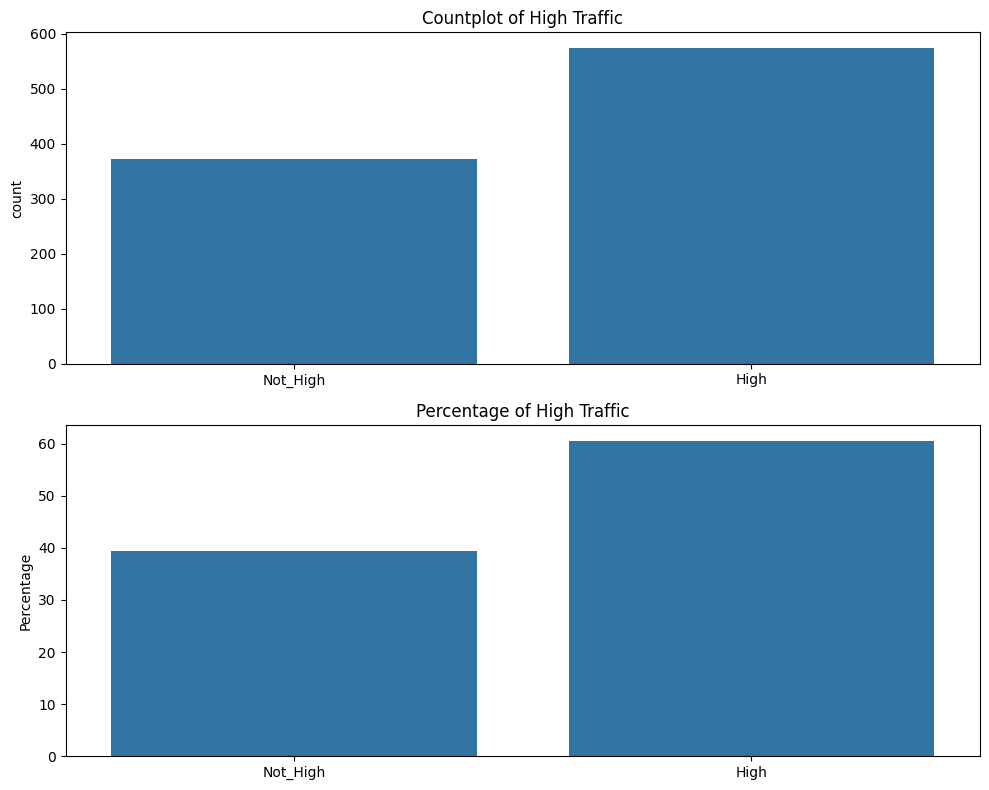

In [533]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot countplot for high_traffic column
sns.countplot(x='high_traffic', data=df, ax=axes[0])
axes[0].set_xticklabels(labels=['Not_High', 'High'])
axes[0].set_title('Countplot of High Traffic')
axes[0].set_xlabel('')

# Plot countplot as percentages
percentage_counts = df['high_traffic'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_counts.index, y=percentage_counts.values, ax=axes[1])
axes[1].set_xticklabels(labels=['Not_High', 'High'])
axes[1].set_title('Percentage of High Traffic')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

First, we can notice that Vegetables and Potato generate high traffic when posted, in percentage terms, while Beverages and Breakfast have the lowest high traffic percentages.

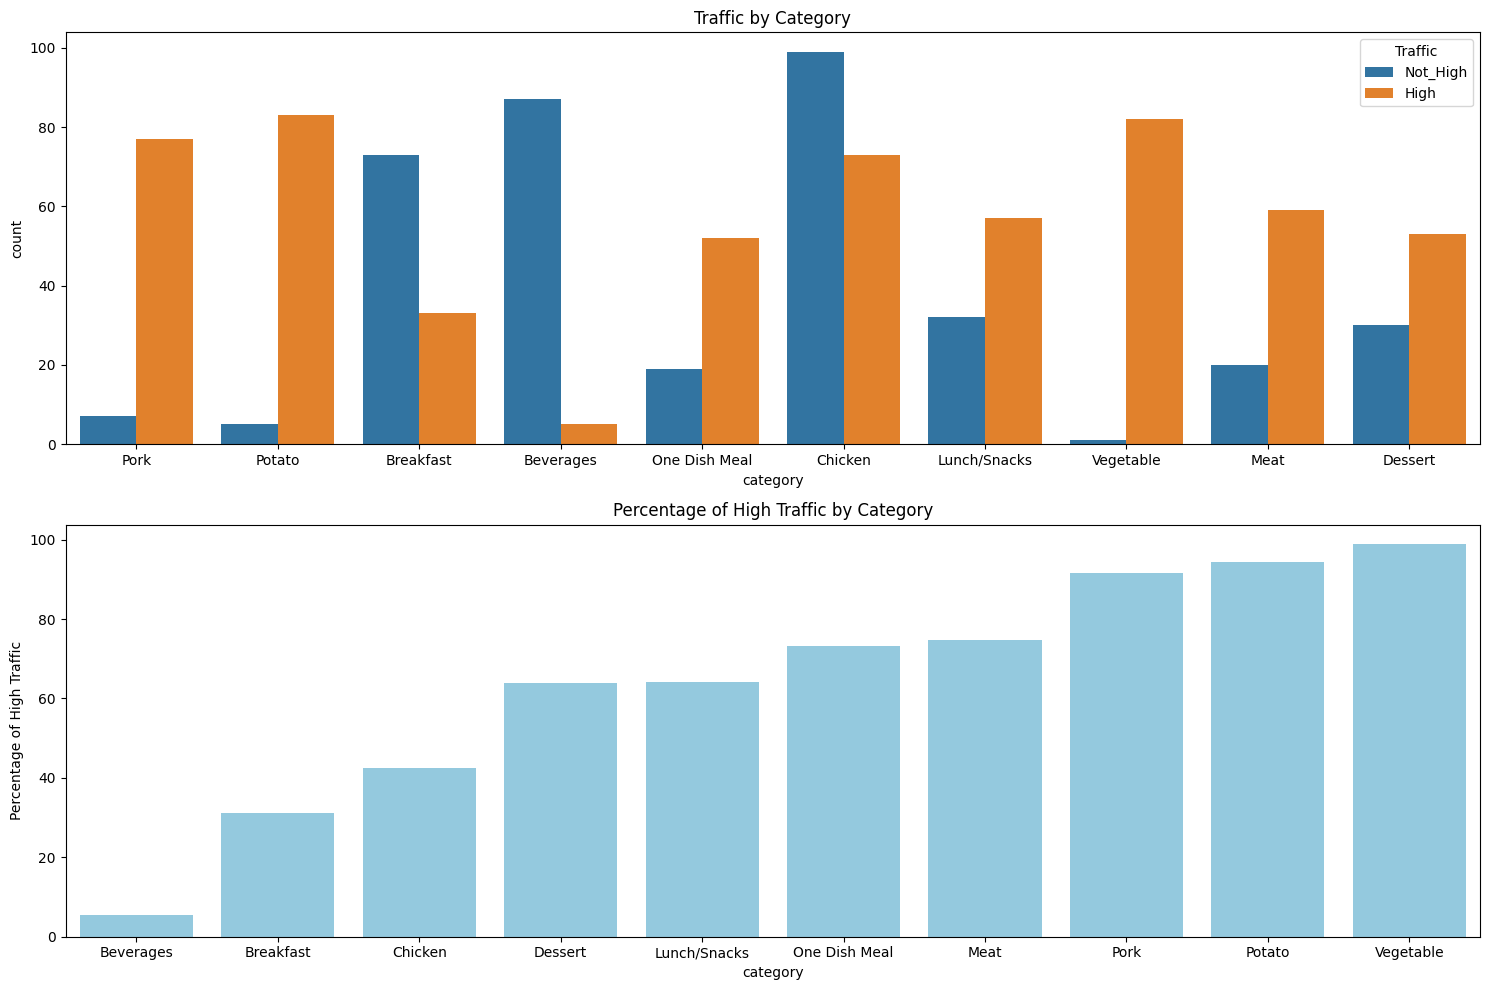

In [534]:
percentage_high_traffic = df.groupby('category')['high_traffic'].mean() * 100
percentage_high_traffic = percentage_high_traffic.sort_values(ascending=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Countplot
sns.countplot(x='category', hue='high_traffic', data=df, ax=ax1)
ax1.legend(title='Traffic', labels=['Not_High', 'High'])
ax1.set_title('Traffic by Category')

# Plot 2: Percentage of 'High' traffic for each category
sns.barplot(x=percentage_high_traffic.index, y=percentage_high_traffic.values, color='skyblue', ax=ax2)
#ax2.set_xticklabels(category_names, rotation=45)
ax2.set_title('Percentage of High Traffic by Category')
ax2.set_ylabel('Percentage of High Traffic')

plt.tight_layout()
plt.show()

Second, correlation of high traffic with any of 'calories', 'carbohydrates', 'protein' or 'sugar' is very low, indicating people are not looking for macros in a first moment.

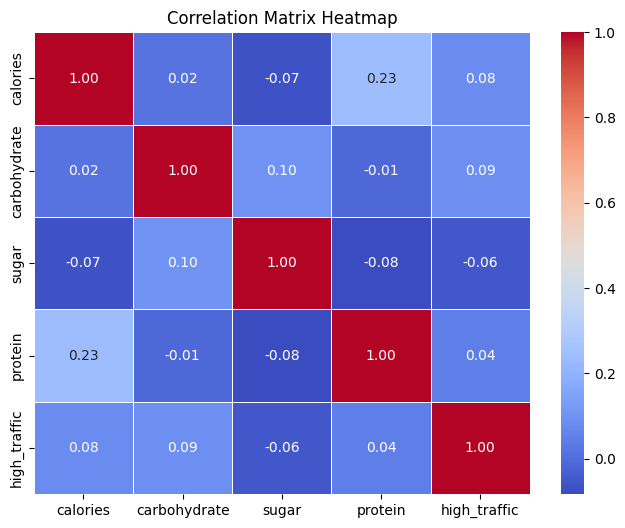

In [535]:
correlation_matrix = df[columns_to_fill + ['high_traffic']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

For the relationship of number of servings and high traffic we see that proportions are similar. Further analysis with a hypothesis test to check if the proportions are significantly different would be appropriate in a second step. For now we will focus on prediction and classification of high traffic with all features we have.

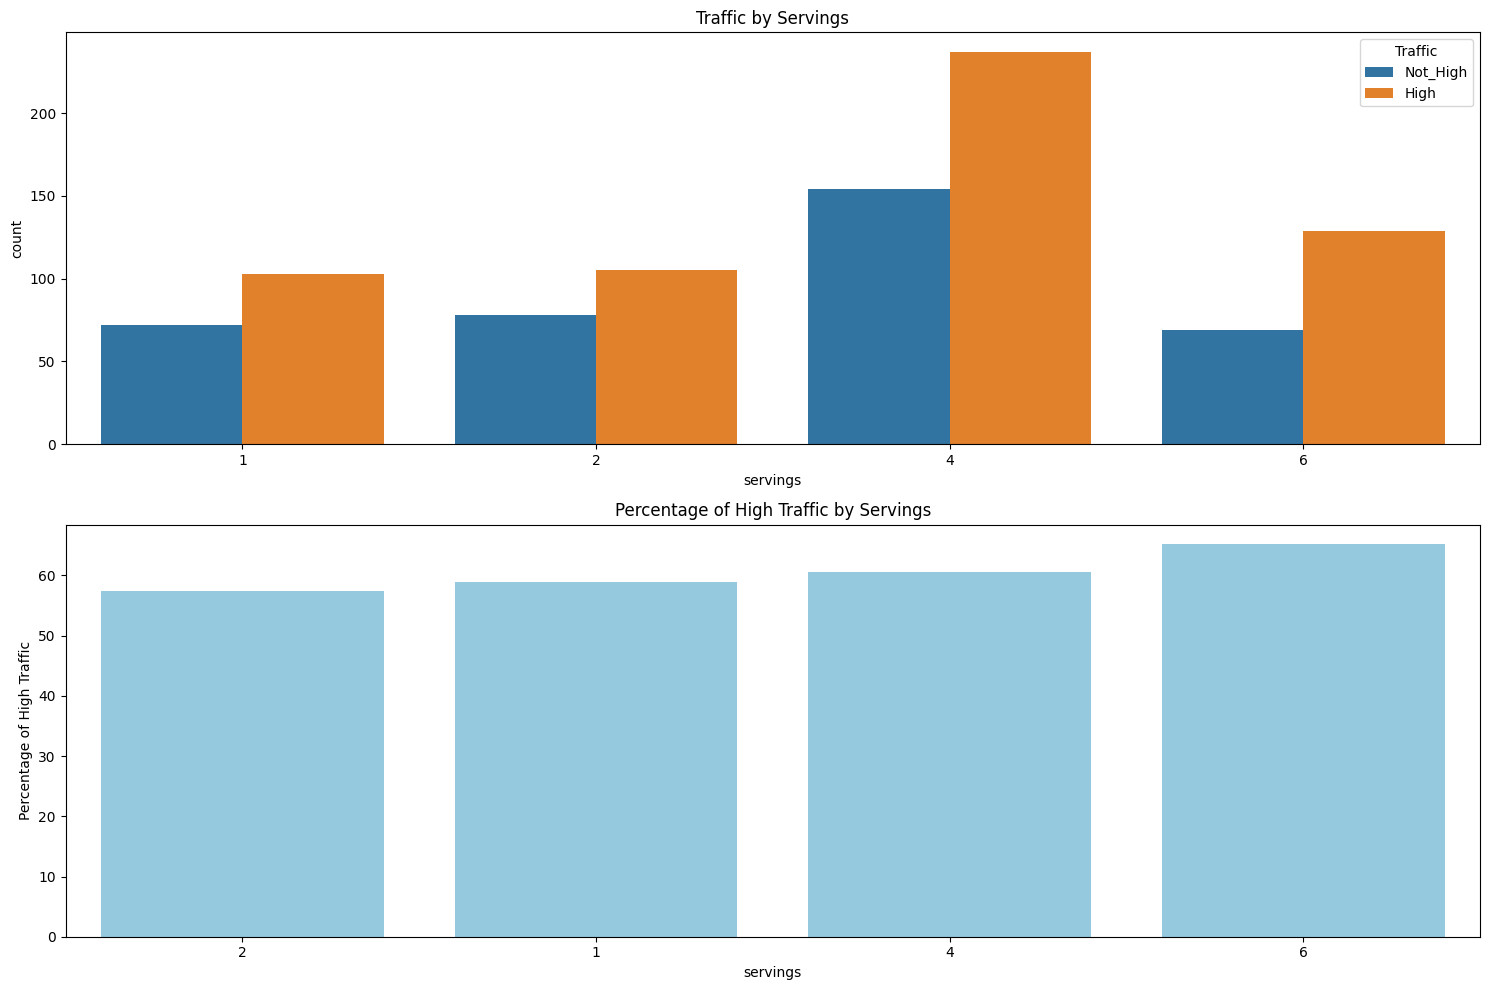

In [536]:
percentage_high_traffic_servings = df.groupby('servings')['high_traffic'].mean() * 100
percentage_high_traffic_servings = percentage_high_traffic_servings.sort_values(ascending=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Countplot
sns.countplot(x='servings', hue='high_traffic', data=df, ax=ax1)
ax1.legend(title='Traffic', labels=['Not_High', 'High'])
#ax1.set_xticklabels(category_names, rotation=45)
ax1.set_title('Traffic by Servings')

order = percentage_high_traffic_servings.index.astype(str)

# Plot 2: Percentage of 'High' traffic for each category
sns.barplot(x=order, y=percentage_high_traffic_servings.values, color='skyblue', ax=ax2, order=order)
ax2.set_title('Percentage of High Traffic by Servings')
ax2.set_ylabel('Percentage of High Traffic')

plt.tight_layout()
plt.show()

For category column, we use LabelEncoder and save the mapping.

In [537]:
label_encoder_cat = LabelEncoder()
df['category'] = label_encoder_cat.fit_transform(df['category'])
category_map = {index: category for index, category in enumerate(label_encoder_cat.classes_)}

In [538]:
df.head(30)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,1449.308288,68.328699,18.094795,95.364658,7,6,1
1,2,35.480000,38.560000,0.660000,0.920000,8,4,1
2,3,914.280000,42.680000,3.090000,2.880000,1,1,0
3,4,97.030000,30.560000,38.630000,0.020000,0,4,1
4,5,27.050000,1.850000,0.800000,0.530000,0,4,0
5,6,691.150000,3.460000,1.650000,53.930000,6,2,1
6,7,183.940000,47.950000,9.750000,46.710000,2,4,0
7,8,299.140000,3.170000,0.400000,32.400000,4,4,0
8,9,538.520000,3.780000,3.370000,3.790000,7,6,1
9,10,248.280000,48.540000,3.990000,113.850000,2,2,0


## Model Fitting

The problem is a **classification problem** where we want to classify a given recipe into High Traffic (label 1) or Not High Traffic (label 0). We will use two approaches: **Logistic Regression** and **Gradient Boosting**.

For each of the columns calories, carbohydrate, sugar, protein, let us plot a histogram to check their distribution.

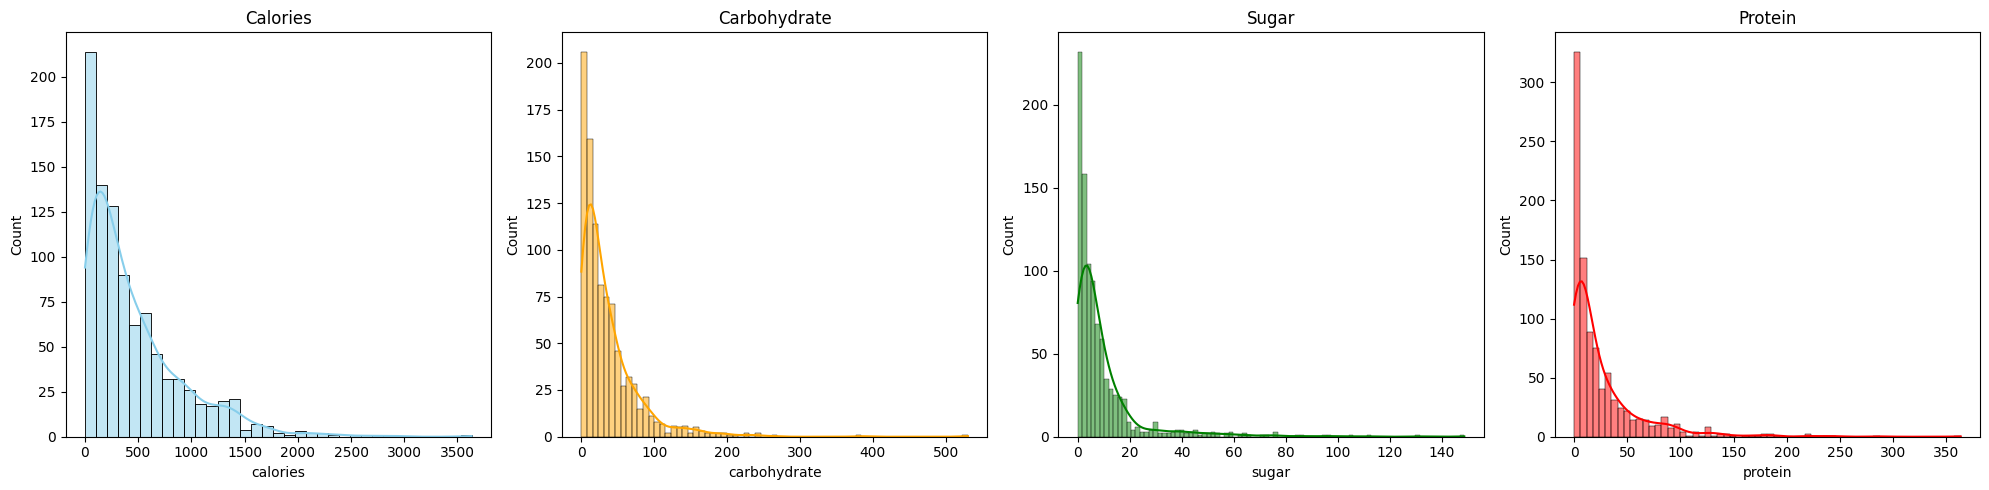

In [539]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(df['calories'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Calories')

sns.histplot(df['carbohydrate'], ax=axes[1], kde=True, color='orange')
axes[1].set_title('Carbohydrate')

sns.histplot(df['sugar'], ax=axes[2], kde=True, color='green')
axes[2].set_title('Sugar')

sns.histplot(df['protein'], ax=axes[3], kde=True, color='red')
axes[3].set_title('Protein')

plt.tight_layout()
plt.show()

As we can see, all of them are rightly skewed we will use PowerTransformer on these columns. In fact, our approaches will be LogisticRegression and Gradient Boosting. While it is not strictly necessary to use PowerTransformer before applying Gradient Boosting, it can be beneficial for improving model stability and accuracy. For Logistic Regression, PowerTransformer may be more useful, especially when the features are highly skewed as we see.

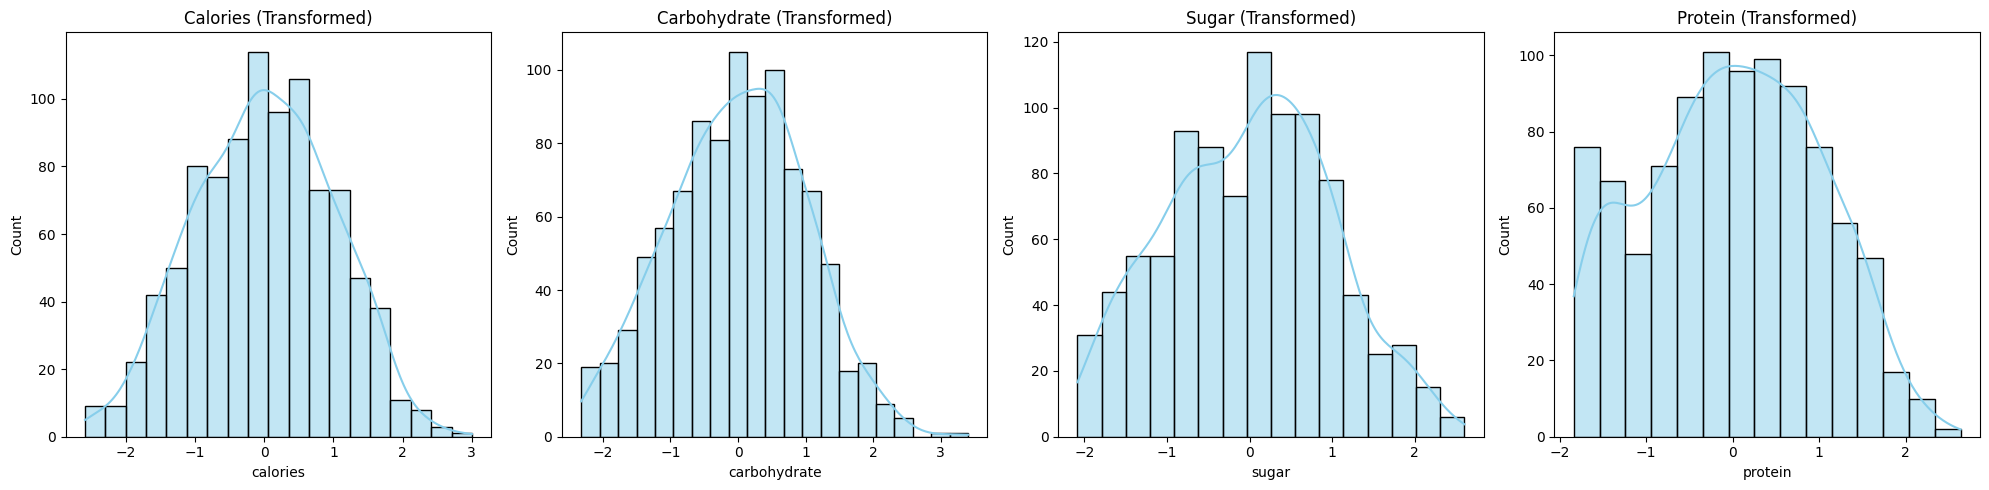

In [540]:
pt = PowerTransformer()

# Fit and transform the specified columns
df[columns_to_fill] = pt.fit_transform(df[columns_to_fill])

# Plot histograms after transformation
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, column in enumerate(columns_to_fill):
    sns.histplot(df[column], ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(column.capitalize() + ' (Transformed)')
plt.tight_layout()
plt.show()

Now we proceed with train and test split. As recipe is just a key-index we drop it from analysis.

In [541]:
X = df.drop(columns=['high_traffic','recipe'])  # Features
y = df['high_traffic']  # Target variable
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

And apply our first algorithm. Logistic Regression

In [542]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(X_test)

Now we apply GradientBoostingClassifier with KFold shuffled spit of train data and GridSearch for optimal parametrization within the range we chose for some parameters of the model.

In [543]:
gb_classifier = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate': [0.01, 0.02, 0.1],
    'max_depth': [1, 3, 5]
}
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.7674333698430084


In [544]:
best_model = grid_search.best_estimator_
y_pred_gb = best_model.predict(X_test)

## Model Evaluation

Let us take a look at the classification report and confusion matrix of each model

In [545]:
print('Classification_report for Logistic Regression\n')
print(classification_report(y_test, y_pred_lr))
print('Classification_report for Gradient Boosting\n')
print(classification_report(y_test, y_pred_gb))

Classification_report for Logistic Regression

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       107
           1       0.82      0.76      0.79       178

    accuracy                           0.75       285
   macro avg       0.73      0.74      0.74       285
weighted avg       0.75      0.75      0.75       285

Classification_report for Gradient Boosting

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       107
           1       0.79      0.84      0.81       178

    accuracy                           0.76       285
   macro avg       0.75      0.74      0.74       285
weighted avg       0.76      0.76      0.76       285



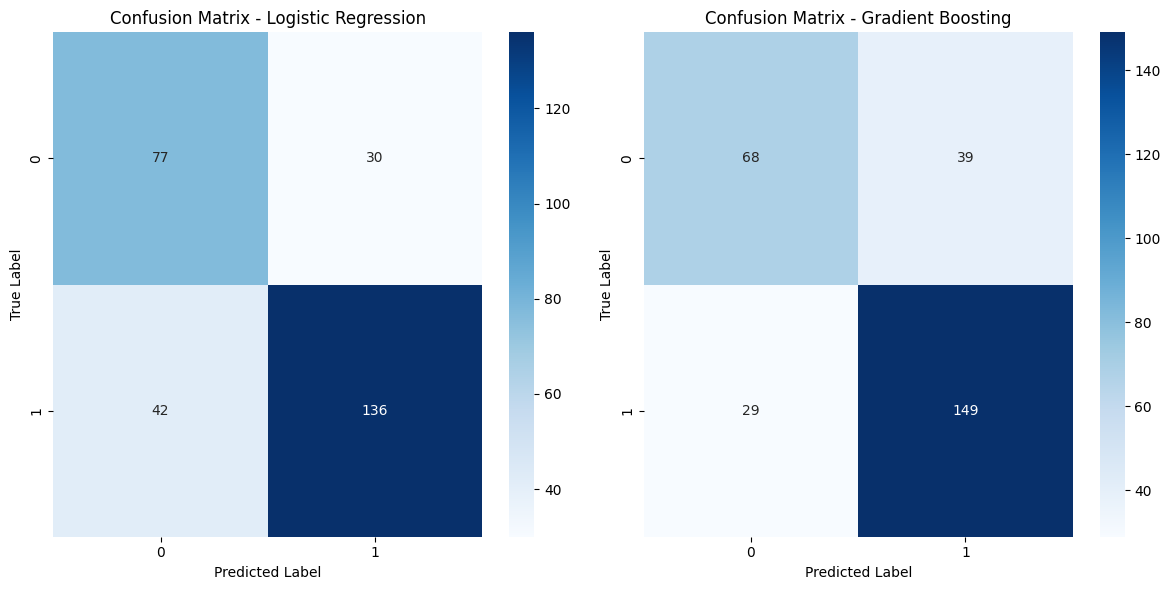

In [546]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix for Logistic Regression
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot confusion matrix for Gradient Boosting
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Gradient Boosting')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Notice that our goal was stated as: 
1. **Predict which recipes will lead to high traffic**
2. **Correctly predict high traffic recipes 80% of the time**

**We can interpret (1) as Precision and (2) as a Recall of 80%.**

* Recall measures the proportion of actual positive cases that were correctly identified by the model. It is the ability of the classifier to find all positive instances.

Formula: 
Recall = True Positives / (True Positives + False Negatives)

* Precision measures the proportion of predicted positive cases that were actually positive. It is the ability of the classifier not to label negative instances as positive.

Formula: 
Precision = True Positives / (True Positives + False Positives)

* Accuracy represents the proportion of correctly classified instances out of all the instances in the dataset. It provides an overall assessment of the model's performance across all classes.

Formula:
Accuracy = Number of Correct Predictions / Total Number of Predictions


Of course, as a general goal a high accuracy is important, because we want to identify both cases (High and Not_High) correclty most of the time. That is why I chose 'accuracy' as the scoring metric of the Grid Search for Gradient Boosting.

Notice that Gradient Boosting beats Logistic Regression in recall and accuracy, but loses in Precision. Finally, only for Gradient Boosting **Recall is greater than 80%**. So we keep this as our best model.

## Business Focus

The business goals of the project were stated above:
1. **Predict which recipes will lead to high traffic**
2. **Correctly predict high traffic recipes 80% of the time**

The present work addresses the problem by developing a machine learning model that classifies a given recipe into High Traffic or Non-High Traffic. We aimed at a recall higher than 80% while having high accuracy and precision. Below you will find recommendations.

## Business Metrics

To compare model performance to business criteria first KPI is **recall**, and it should be higher than 80%. Second KPI is precision and third KPI is accuracy. All were defined in model Valuation session.

We also compared the two models with these KPI's. Gradient Boosting had higher recall and accuracy, and lower precision. Also, Gradient Boosting was the only model with recall higher than 80%.

## Recommendation

As recommendations for future action:
* it would be good to perform a hypothesis test on number of servings to check if proportion of high traffic is significant statistically different for each number of servings;
* Keep updating the model when more data comes into play to check the KPI's (precision, recall and accuracy).
* Try different models and transformation of data to check if performance improves. For example we could have used more options in PowerTransformer to transform columns calories, carbohydrate, sugar, protein.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation